# House Prices Project

The task in this project is to predict house prices based on multiple features. Data comes from the kaggle competition [kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). All data transformations are wrapped in sklearn transformers so that the inference can be done outside of this notebook without repeating all preprocessing steps. I have made a simple app [Heroku](https://house-prices-prediction-serv.herokuapp.com/) which allows printing single records from the test data in *json* format and predicting house prices. The API is described in the github repo [github](https://github.com/twrzeszcz/house-prices-project). There is also an interactive streamlit app where one can perform EDA, examine feature importances, and compare models performance.

# Analysis and preprocessing

Lets first import all dependencies and also define a function which allows to extract feature names from sklearn pipelines.

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.svm import SVR
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone 
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
import pickle
from scipy.stats import skew
from scipy.special import boxcox1p

%matplotlib inline

In [85]:
import warnings

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

Firstly we will peform some data analysis with combined test and train data. All applied transformations will be done separately so that there is no data leakage from train set to test set.

In [86]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [87]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)

In [88]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [90]:
df.duplicated().sum()

0

There are a lot of missing values as it can be seen below. One of the main part of preprocessing will be to fill them in some way. It is not visible here but some features have missing values in test data but not in the train data.

In [91]:
df.isna().sum()[df.isna().sum() != 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

Now lets look at the correlations between the features.

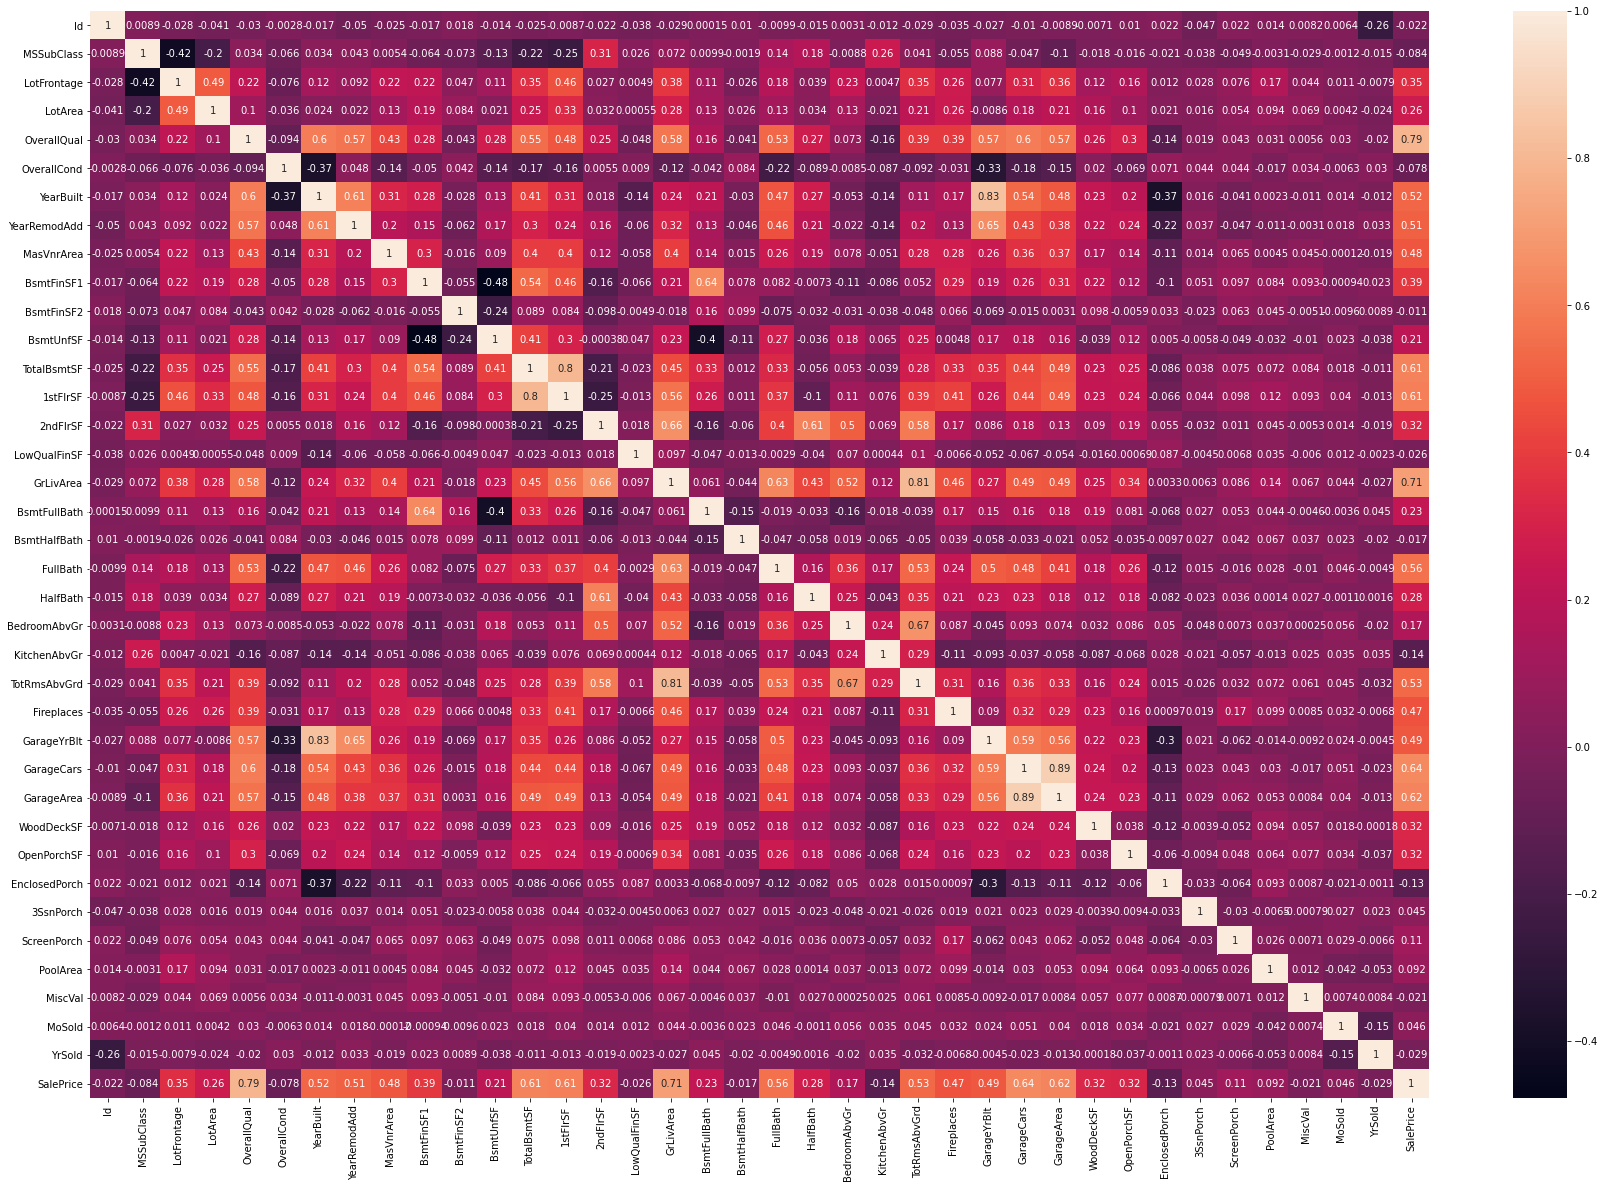

In [46]:
plt.figure(figsize=(30,20))
sns.heatmap(df.corr(), annot=True)

Below you can see correlations between features and the target.

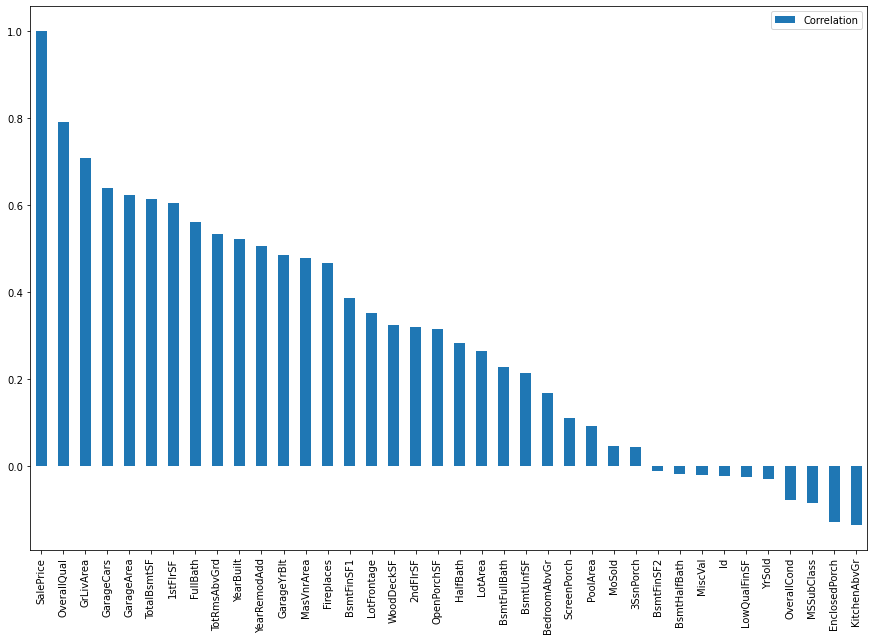

In [47]:
target_corr = df.corr()['SalePrice'].sort_values(ascending=False)
target_corr_df = pd.DataFrame({'Correlation': target_corr.values}, index=target_corr.index)
target_corr_df.plot(kind='bar', figsize=(15,10))

When we plot *GrLivArea* over the *SalePrice* we can easily spot 2 outliers in the bottom right corner which in this case have to be removed as they will strongly decrease performance of our models. We should not remove more records as our dataset is already very small.

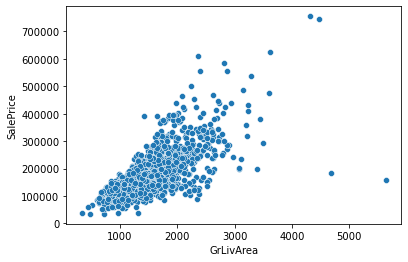

In [48]:
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')

In [92]:
df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)].index, inplace=True)

Lets now look at the distributions of numerical features.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly c

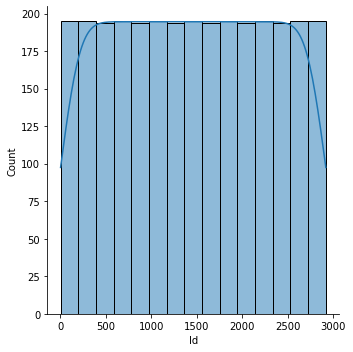

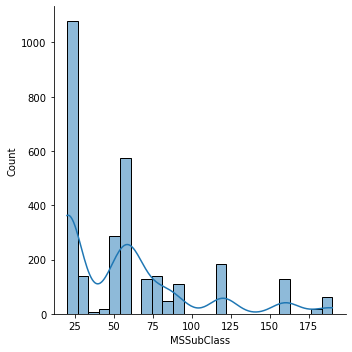

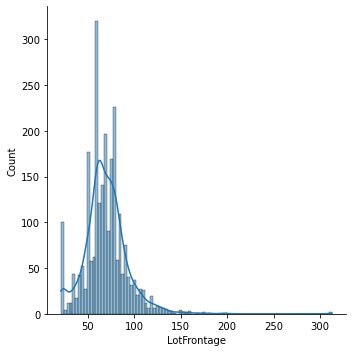

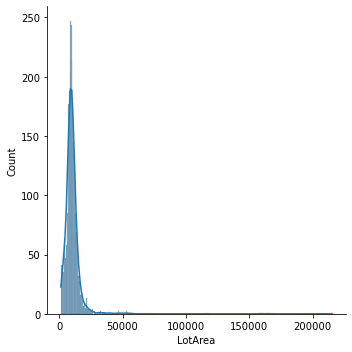

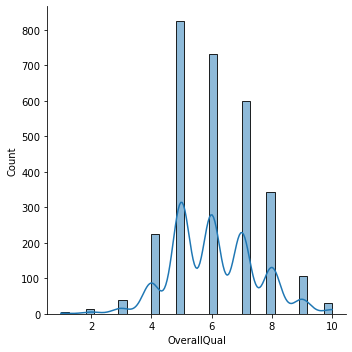

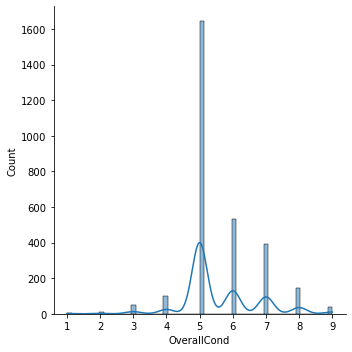

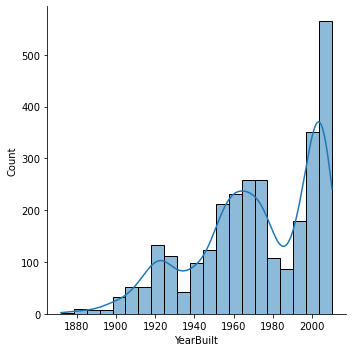

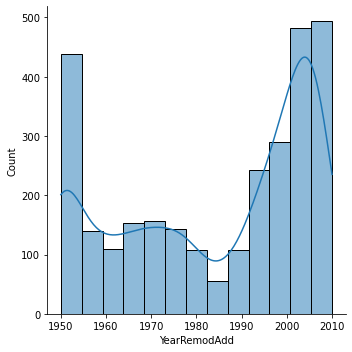

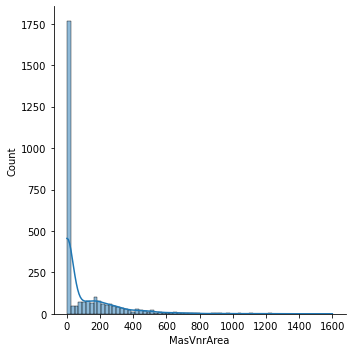

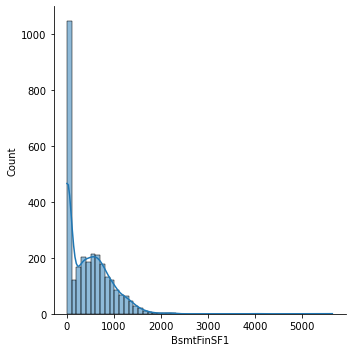

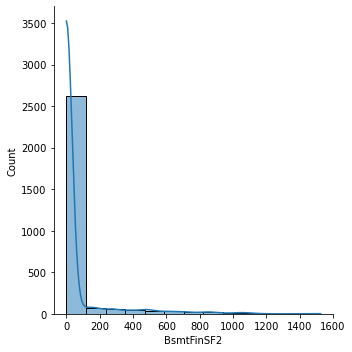

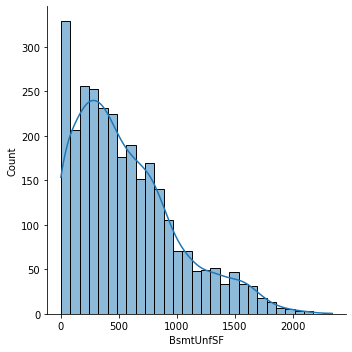

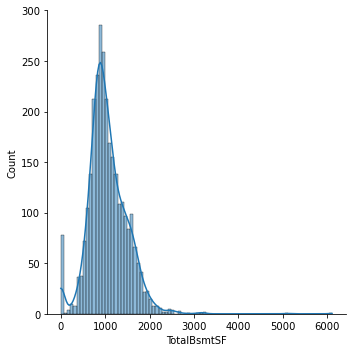

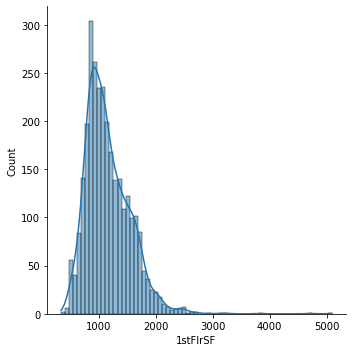

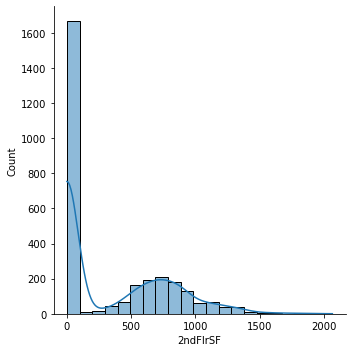

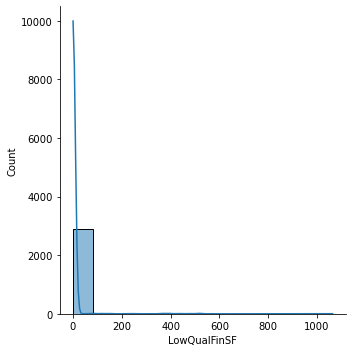

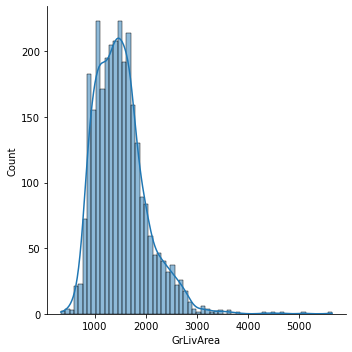

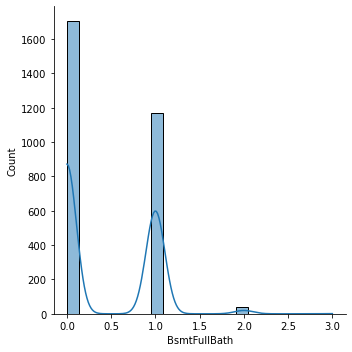

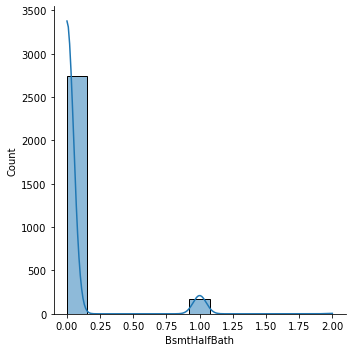

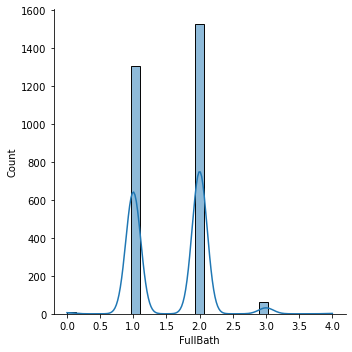

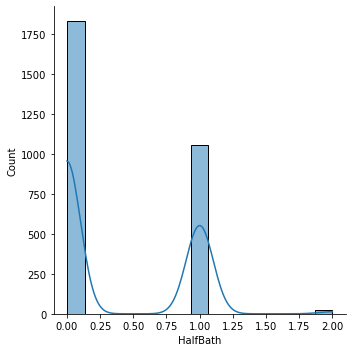

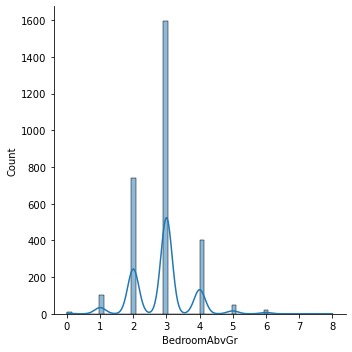

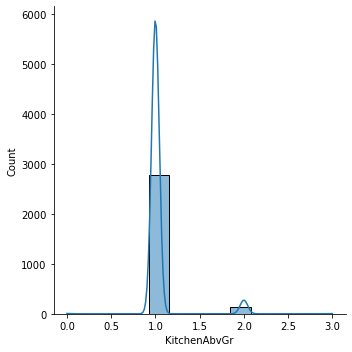

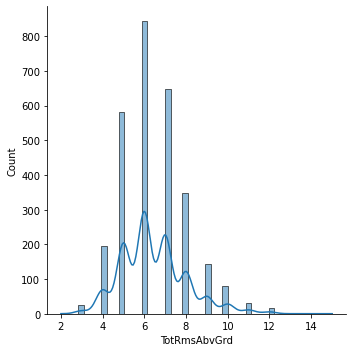

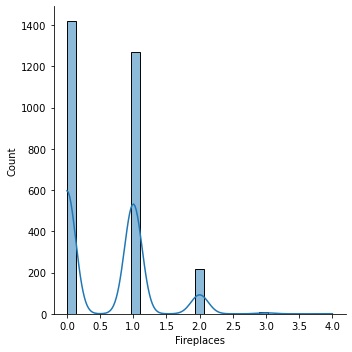

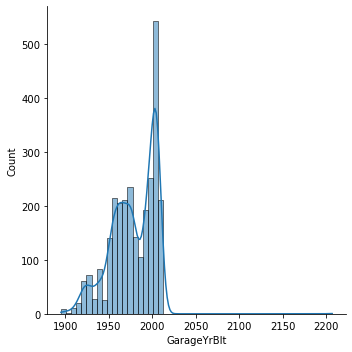

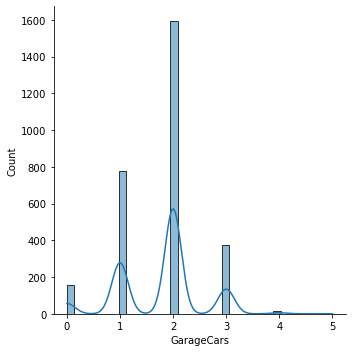

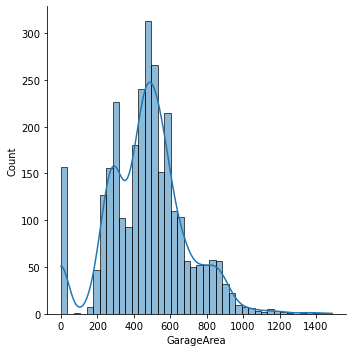

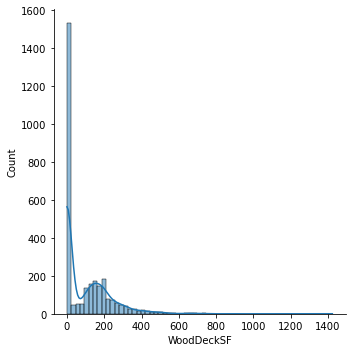

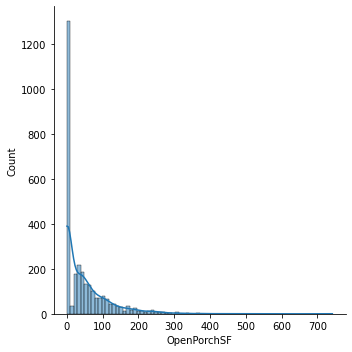

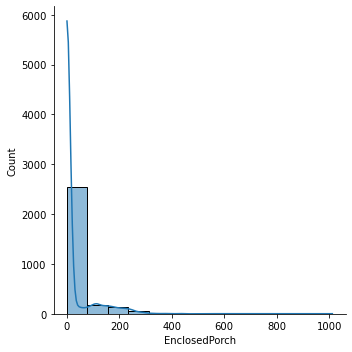

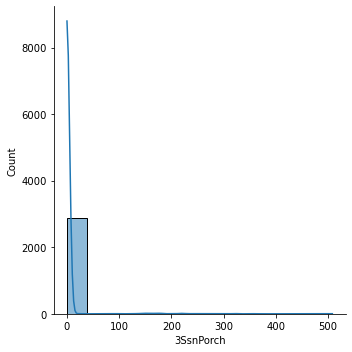

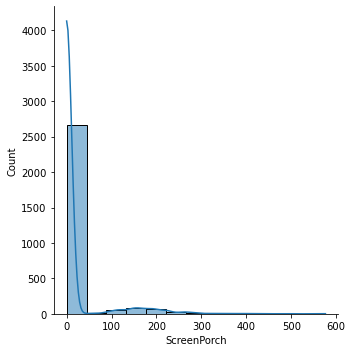

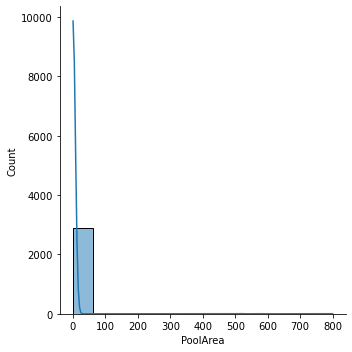

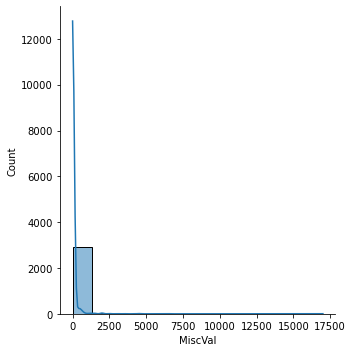

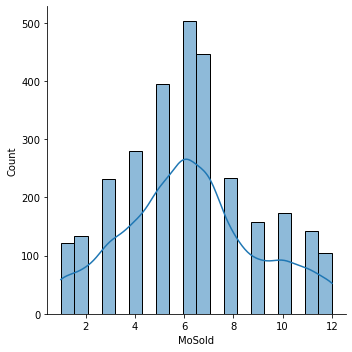

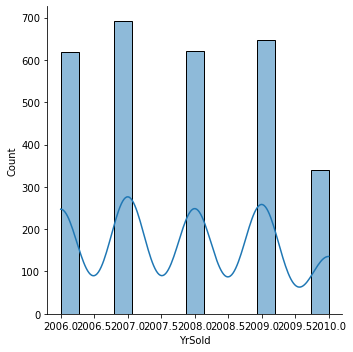

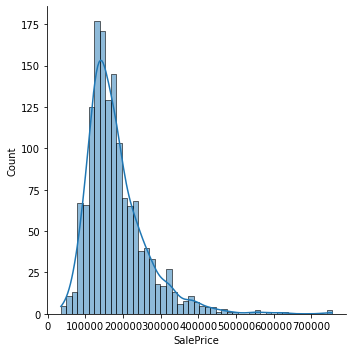

In [50]:
for i in df.describe().columns:
    sns.displot(df[i], kde=True)

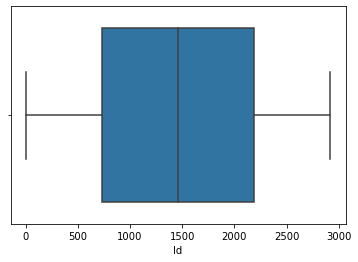

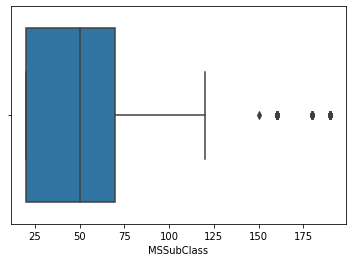

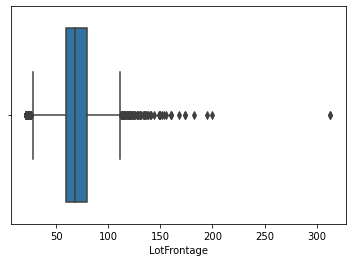

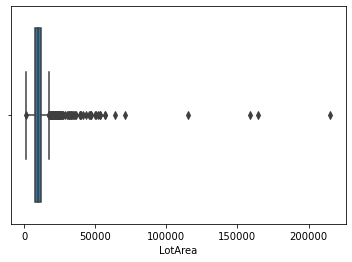

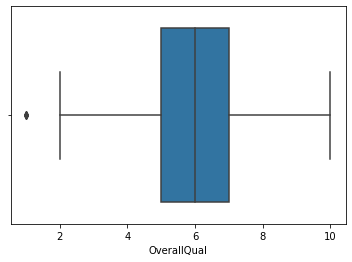

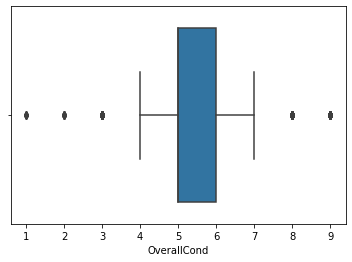

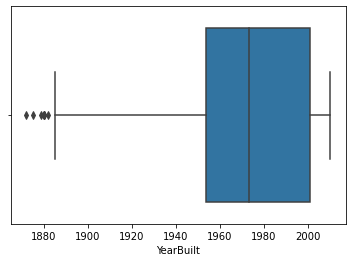

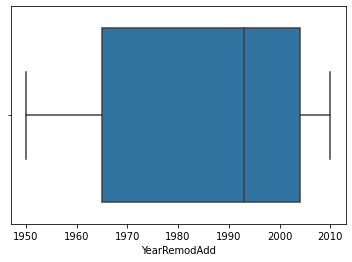

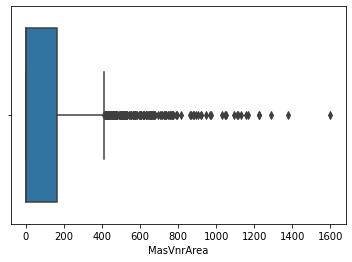

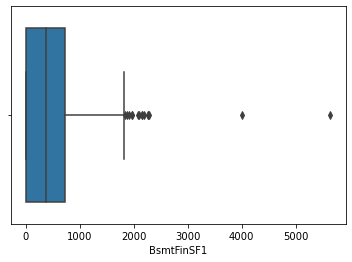

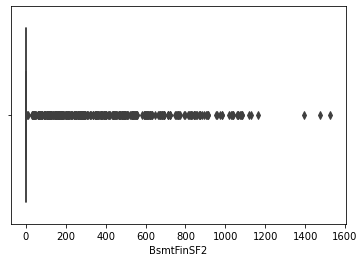

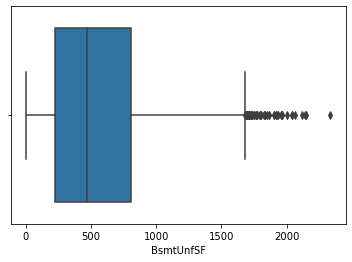

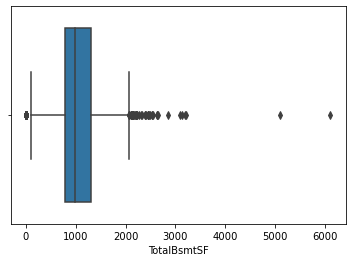

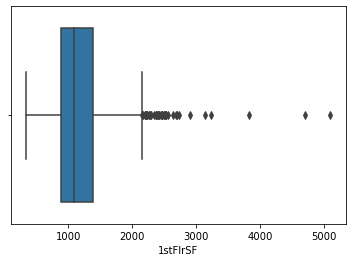

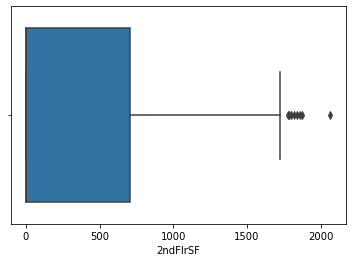

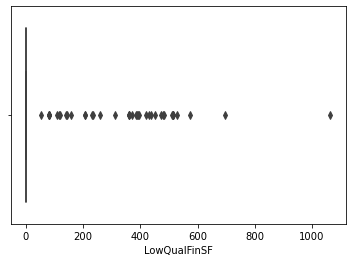

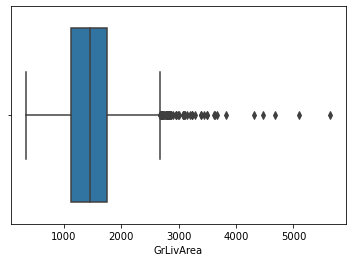

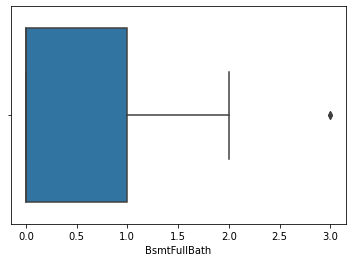

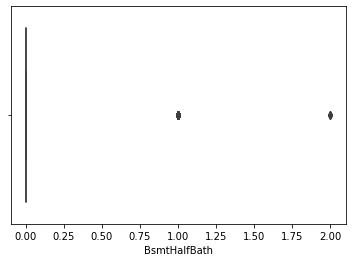

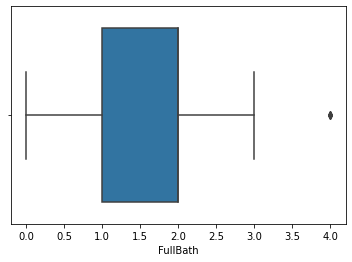

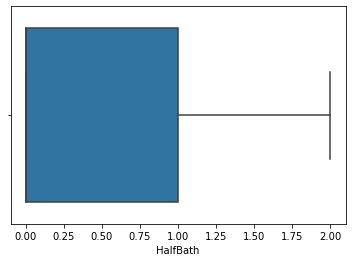

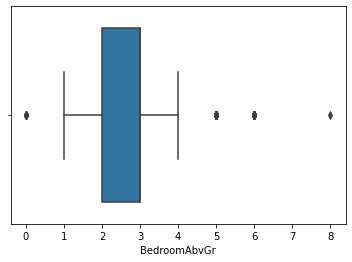

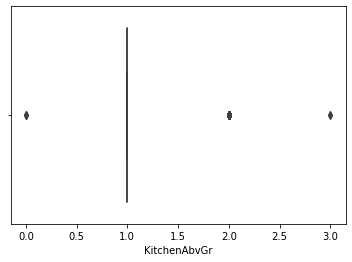

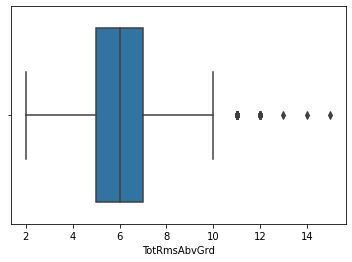

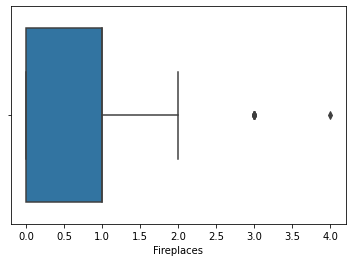

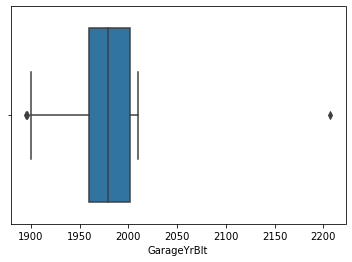

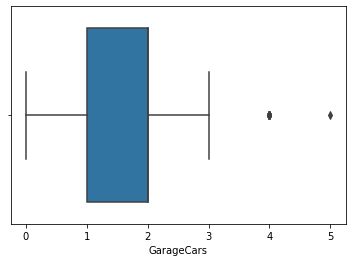

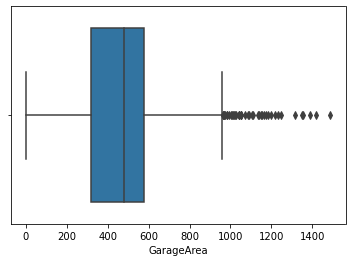

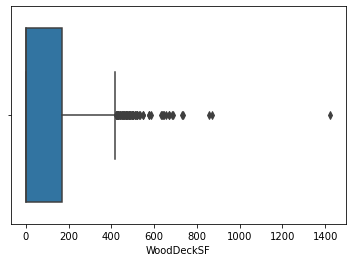

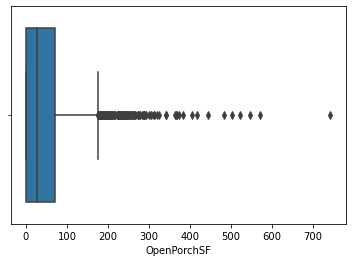

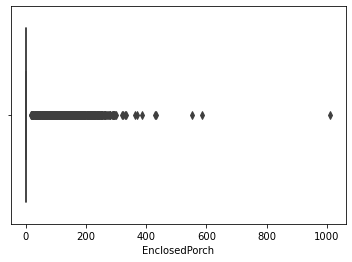

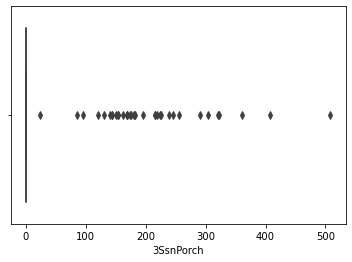

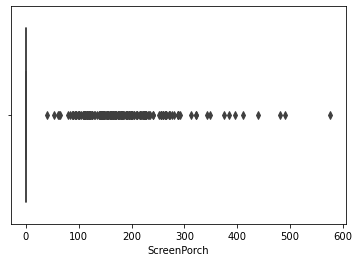

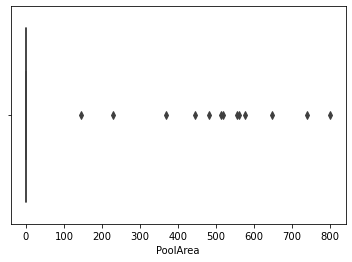

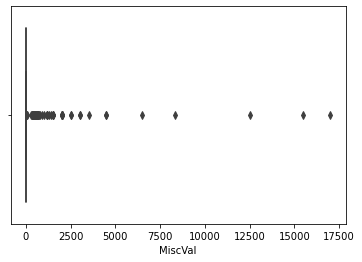

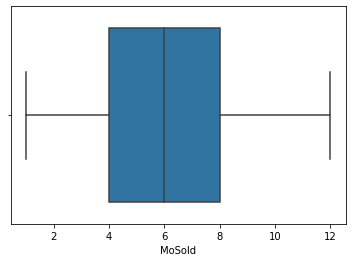

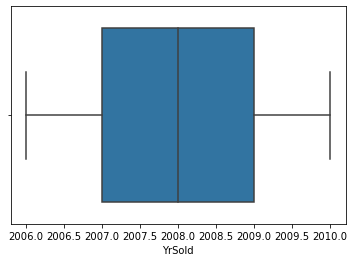

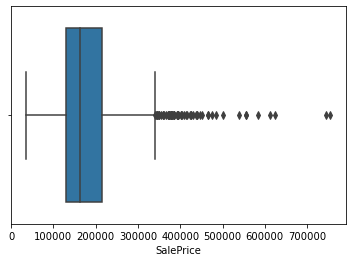

In [51]:
for i in df.describe().columns:
    sns.boxplot(x=df[i])
    plt.show()

As you could see above, many features are skewed and we should somehow fix it. This is the next preprocessing step which will be done. Now lets also look at the categorical features.

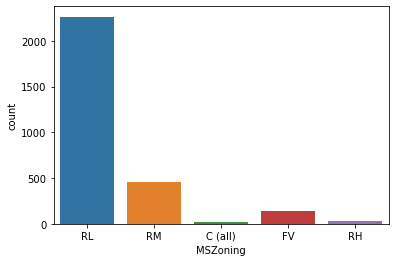

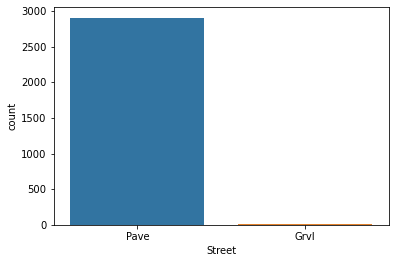

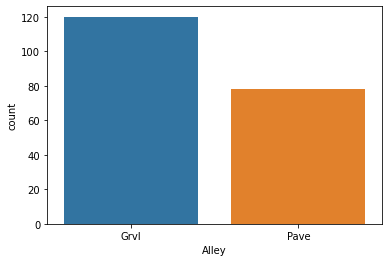

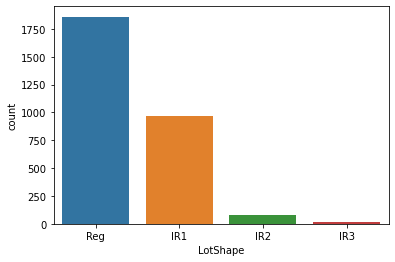

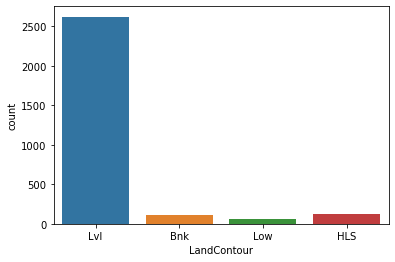

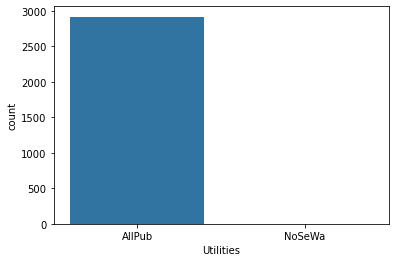

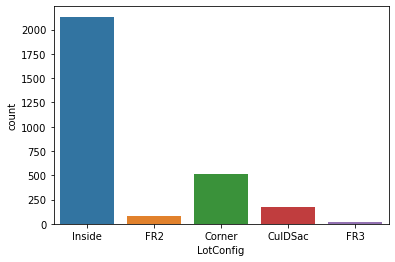

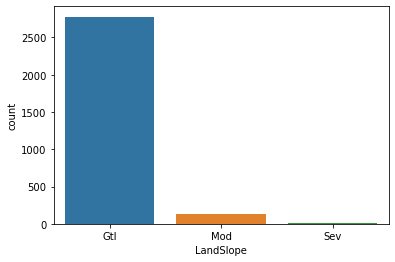

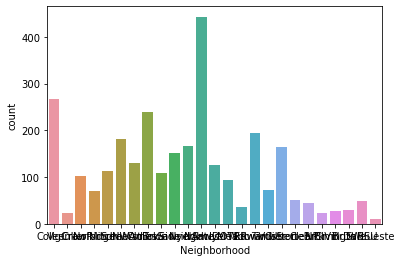

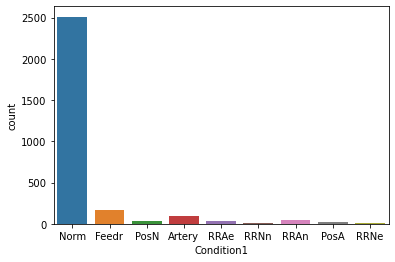

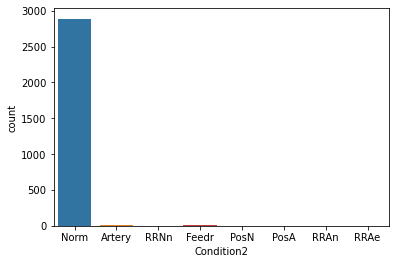

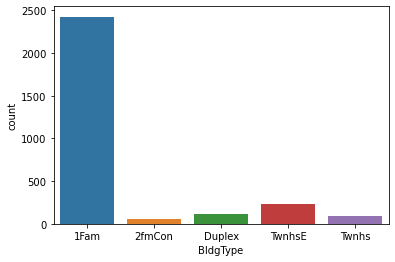

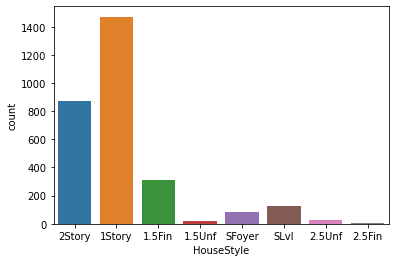

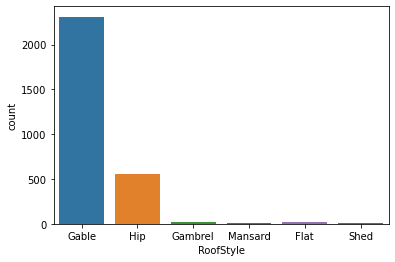

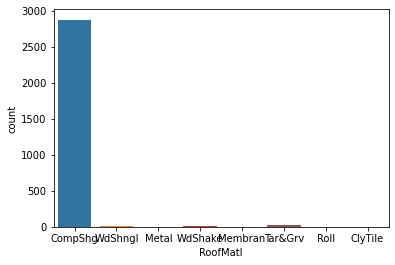

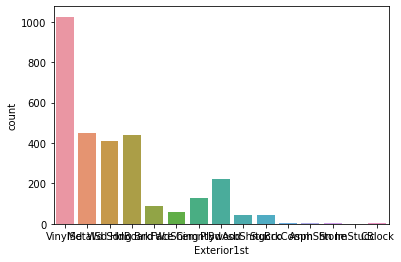

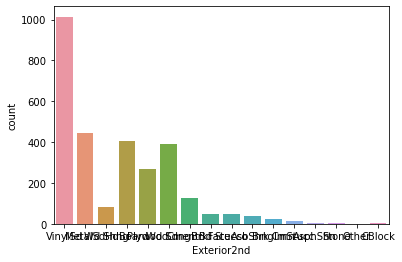

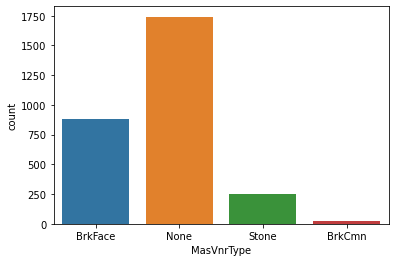

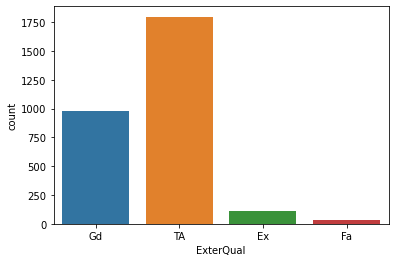

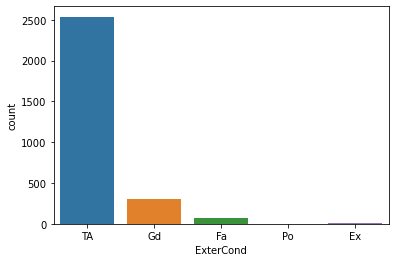

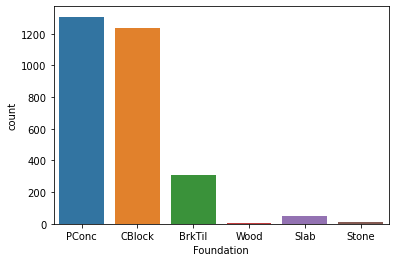

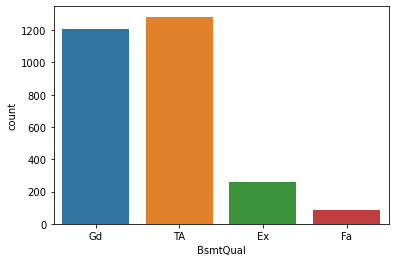

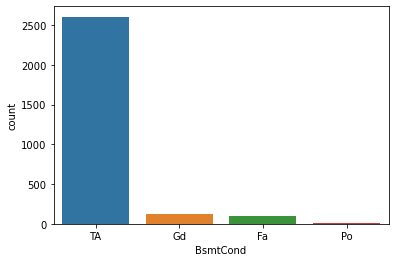

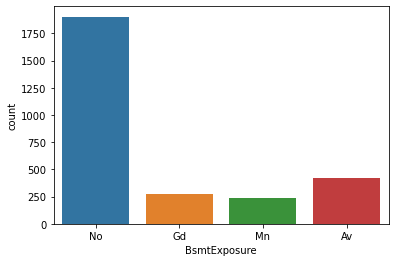

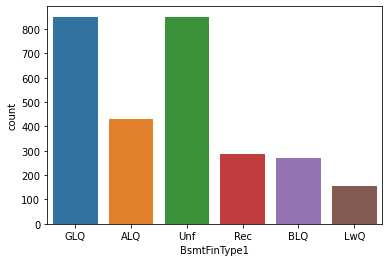

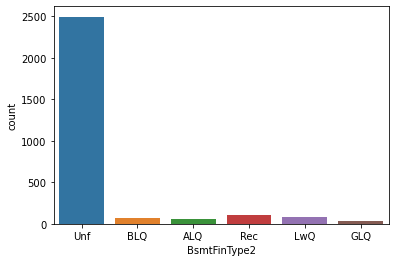

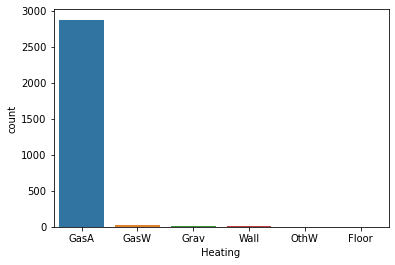

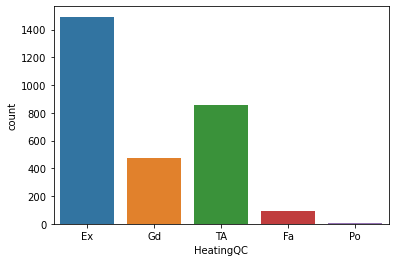

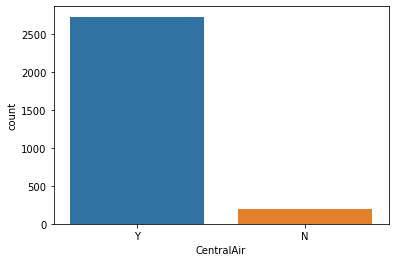

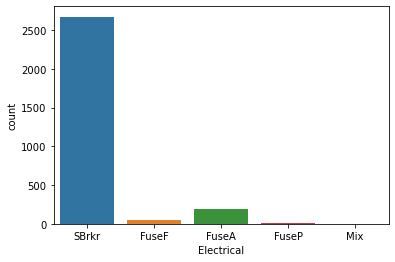

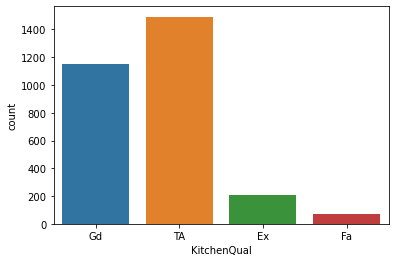

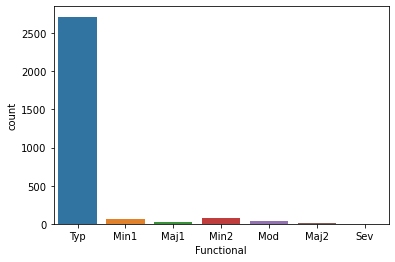

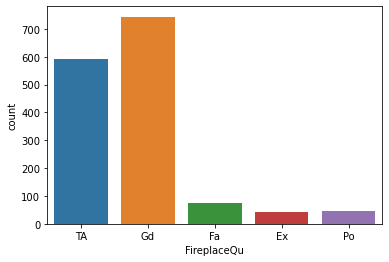

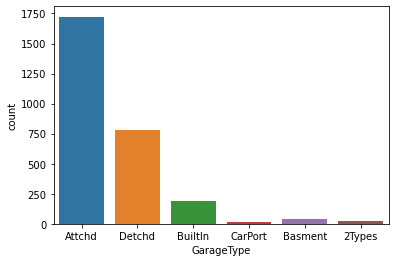

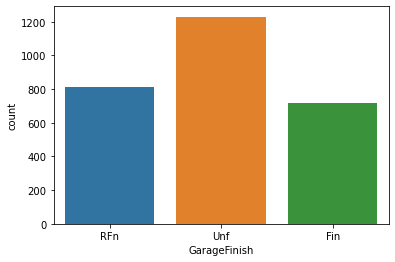

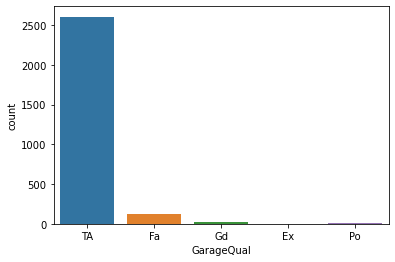

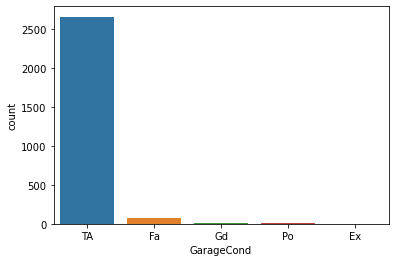

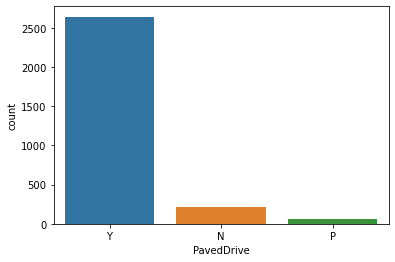

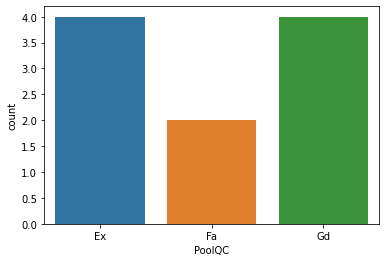

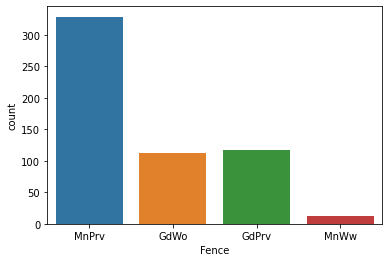

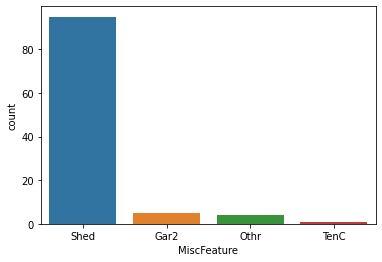

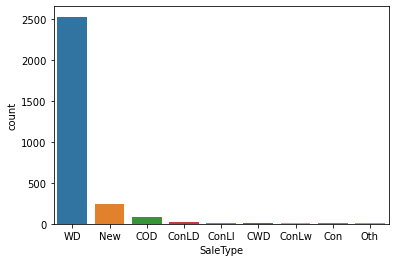

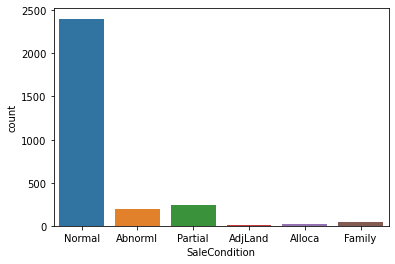

In [52]:
for i in df.select_dtypes('object').columns:
    sns.countplot(x=df[i])
    plt.show()

There is much more data analysis that can be done including combinations of different numerical/categorical features and inspection of their dependence on each other. One can do this in the streamlit app for this project. Now lets move to the preprocessing step.

Firstly I will impute the missing values. As it was mentioned before, there are some features which have missing values only in the test or train set. This is not a problem, cause if we impute missing values in the dataset which has no missing values for a specific feature, nothing will happen. There are certain groups of features which describe a specific item e.g., *Garage* or *Basement*. Missing values in some of these features for a single record means that in this house there is no e.g, *Garage*. We can therefore impute such values with *NA/None* according to the provided *data_description* file. If there are some numerical features which also correspond to the missing items like *GarageArea*, we should replace them with 0. For the other categorical features we choose the most frequent category for replacement. There is also a *Functional* feature which should be replaced with a *Typ* category according to the description. *MSSubClass* feature has a wrong type and it should be converted to the categorical feature according to the description. In this step we also create a single new feature which is a total area of a house meaning *basement + 1st_floor + 2nd_floor*. This could help our models as the house price is heavily dependent on its area.

All these transformations are wrapped in a single transformer which is fitted on the train set and then transformed on the test set.

In [93]:
class all_purpose_transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        X_new = X.copy()
        self.cols = ['MSZoning', 'SaleType', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Electrical'] 
        self.mode_to_replace = {col: X_new[col].mode()[0] for col in self.cols}
        
        return self
        
    def transform(self, X):
        X_new = X.copy()
        
        # impute with NA/None
        for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
            X_new[col] = X_new[col].fillna('NA')
        for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
            X_new[col] = X_new[col].fillna('NA')  
        X_new['FireplaceQu'].fillna('NA', inplace=True)
        X_new['MasVnrType'].fillna('None', inplace=True)
        X_new['Alley'].fillna('NA', inplace=True)
        X_new['PoolQC'].fillna('NA', inplace=True)
        X_new['Fence'].fillna('NA', inplace=True)
        X_new['MiscFeature'].fillna('NA', inplace=True)

        # impute with 0
        for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
            X_new[col] = X_new[col].fillna(0)
        for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
            X_new[col] = X_new[col].fillna(0)

        X_new['MasVnrArea'].fillna(0, inplace=True)
        
        #impute with mode
        for col in self.cols:
            X_new.loc[X_new[col].isna(), col] = self.mode_to_replace[col] 
        
        # other
        X_new['Functional'].fillna('Typ', inplace=True)
        X_new['TotalSF'] = X_new['TotalBsmtSF'] + X_new['1stFlrSF'] + X_new['2ndFlrSF']
        X_new['MSSubClass'] = X_new['MSSubClass'].astype('object')

        X_new.drop(['Utilities', 'Id'], axis=1, inplace=True)
        
        return X_new

We have to impute missing values in one more feature which is the *LotFrontage*. There are a lot of missing values here and we cannot simply impute with 0. From the description we know that this feature describes the length of the part of the street connected to the property. We can assume that within the same neighborhood most of houses should have this length similar so that we will calculate the median of the *LotFrontage* for each neighborhood and then impute missing values according to the neighborhood in which specific house is located.

In [94]:
class custom_imputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        X_new = X.copy()
        self.median_to_replace = X_new.groupby('Neighborhood')['LotFrontage'].median()
        
        return self
    
    def transform(self, X):
        X_new = X.copy()
        for n, value in zip(self.median_to_replace.index, self.median_to_replace.values):
            X_new.loc[(X_new['LotFrontage'].isna()) & (X_new['Neighborhood'] == n), 'LotFrontage'] = value 
        
        return X_new

Now we have no missing values and we can perform the next preprocessing step which is the transformation of the numerical features which are highly skewed. We cannot remove any outliers cause the dataset is very small. The possible option is to apply a *log* function to some features so that the outliers impact is reduced and distributions become less skewed. To check which numerical features should be transformed in this way, we can calculate the skewness of each numerical feature, and based on some defined threshold transform features with skewness larger than this value. Then we apply a *boxcox1p* function which is the modified version of the *log* function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox1p.html).

In [95]:
class skewness_remover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        X_new = X.copy()
        self.skewness = X_new[X_new.describe().columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        self.skewness = self.skewness[self.skewness > 0.75]
        
        return self
        
    def transform(self, X):
        X_new = X.copy()
        for col in self.skewness.index:
            X_new[col] = boxcox1p(X_new[col], 0.15)
        
        return X_new

Now we are almost ready for training. The last step is the encoding of the categorical features with *one_hot_encoder* and scaling the numerical features with a *RobustScaler*. We cannot create a transformer for encoding on the train data cause in for some features in the test data there are categories which are not present in the train set. That is why we fit the encoder to the entire dataset and then use it to transform both test and train sets. Scaler is fitted normally to the train set. 

There is also one very important transformation which has to be applied to the target. We could observe that *SalePrice* distribution is also skewed and this will strongly impact models performance, especially linear ones. That is why we apply the *log* transform again. This way we will also define a metric used to evaluate models performance which is the *Log RMSE*. Instead of subtracting predictions from targets we will subtract their logarithms. This is also the metric used in kaggle to evaluate the performance on the test set.

In [96]:
y = np.log1p(df_train['SalePrice'])
df_train.drop('SalePrice', axis=1, inplace=True)

In [97]:
df.drop('SalePrice', axis=1, inplace=True)
all_purpose_t = all_purpose_transformer()
df = all_purpose_t.fit_transform(df)

cat_cols = df.select_dtypes('object').columns

enc_pipe = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(), cat_cols)
], remainder='passthrough')

enc_pipe.fit(df)

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot_encoder', OneHotEncoder(),
                                 Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])

In [98]:
prep_pipe = Pipeline([
    ('all_purpose_transformer', all_purpose_transformer()),
    ('custom_imputer', custom_imputer()),
    ('skewness_remover', skewness_remover())
])

In [99]:
X_train = prep_pipe.fit_transform(df_train)
X_test = prep_pipe.transform(df_test)

In [100]:
scale_pipe = Pipeline([
    ('scaler', RobustScaler())
])

In [101]:
X_train_prep = scale_pipe.fit_transform(enc_pipe.transform(X_train).toarray())

In [102]:
X_test_prep = scale_pipe.transform(enc_pipe.transform(X_test).toarray())

In [266]:
pickle.dump(prep_pipe, open('prep_pipe.pkl', 'wb'))

In [267]:
pickle.dump(enc_pipe, open('one_hot_enc.pkl', 'wb'))

In [268]:
pickle.dump(scale_pipe, open('scale.pkl', 'wb'))

# Feature importances

Before we try different models I will use a *CatBoostRegressor* to compute feature importances. This model can be trained without encoding categorical features so we can see the importance of each feature and not every category.

In [70]:
num_cols = X_train.describe().columns

num_pipe = Pipeline([
    ('scale', RobustScaler())
])

prep_pipe = ColumnTransformer([
    ('num pipe', num_pipe, num_cols),
], remainder='passthrough')

In [71]:
X_train_prep = prep_pipe.fit_transform(X_train)

In [72]:
X_train_prep_df = pd.DataFrame(X_train_prep, columns=get_feature_names(prep_pipe))

<ipython-input-2-40d3bafd709a>:32: UserWarning: Transformer scale (type RobustScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [73]:
X_train_prep_df.columns[:36]

Index(['num pipe__LotFrontage', 'num pipe__LotArea', 'num pipe__OverallQual',
       'num pipe__OverallCond', 'num pipe__YearBuilt',
       'num pipe__YearRemodAdd', 'num pipe__MasVnrArea',
       'num pipe__BsmtFinSF1', 'num pipe__BsmtFinSF2', 'num pipe__BsmtUnfSF',
       'num pipe__TotalBsmtSF', 'num pipe__1stFlrSF', 'num pipe__2ndFlrSF',
       'num pipe__LowQualFinSF', 'num pipe__GrLivArea',
       'num pipe__BsmtFullBath', 'num pipe__BsmtHalfBath',
       'num pipe__FullBath', 'num pipe__HalfBath', 'num pipe__BedroomAbvGr',
       'num pipe__KitchenAbvGr', 'num pipe__TotRmsAbvGrd',
       'num pipe__Fireplaces', 'num pipe__GarageYrBlt', 'num pipe__GarageCars',
       'num pipe__GarageArea', 'num pipe__WoodDeckSF', 'num pipe__OpenPorchSF',
       'num pipe__EnclosedPorch', 'num pipe__3SsnPorch',
       'num pipe__ScreenPorch', 'num pipe__PoolArea', 'num pipe__MiscVal',
       'num pipe__MoSold', 'num pipe__YrSold', 'num pipe__TotalSF'],
      dtype='object')

In [75]:
cat_model = CatBoostRegressor(cat_features=X_train_prep_df.columns[36:], verbose=0)
cat_model.fit(X_train_prep_df, y)

In [77]:
pickle.dump(cat_model, open('cat_model.pkl', 'wb'))

In [317]:
importances_cat = pd.DataFrame({'Importances': cat_model.feature_importances_}, index=get_feature_names(prep_pipe))

<ipython-input-245-40d3bafd709a>:32: UserWarning: Transformer scale (type RobustScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [318]:
importances_cat['Importances'].sort_values(ascending=False)[:15]

num pipe__TotalSF        21.403164
num pipe__OverallQual    14.460848
num pipe__GrLivArea       5.608514
KitchenQual               5.071468
num pipe__OverallCond     3.471070
num pipe__BsmtFinSF1      2.673279
GarageFinish              2.633454
num pipe__Fireplaces      2.476160
num pipe__LotArea         2.372841
num pipe__YearBuilt       2.344625
CentralAir                2.158897
MSZoning                  2.097648
num pipe__GarageYrBlt     1.967901
num pipe__GarageCars      1.822435
num pipe__TotalBsmtSF     1.803778
Name: Importances, dtype: float64

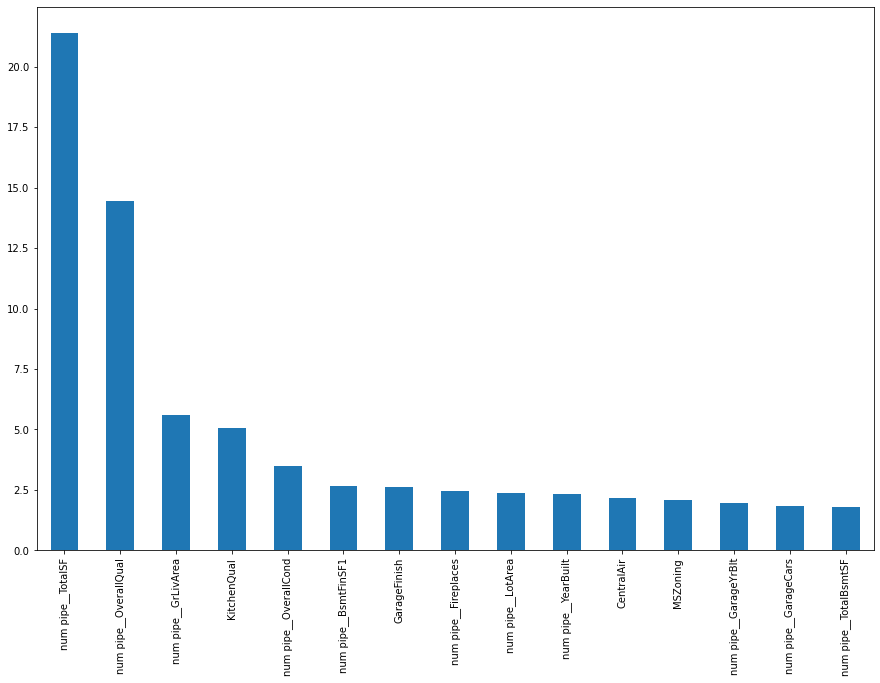

In [319]:
importances_cat['Importances'].sort_values(ascending=False)[:15].plot(kind='bar', figsize=(15,10))

From the above graph we can notice that most of the important features are numerical and the created feature *TotalSF* has the highest score. Now lets move to the model training.

# Training and tuning

Firstly I will check different models with a cross validation to see the baseline scores. We have to modify the scoring method to be the *negative mean squared error*. To get the RMSE we have to take a square root of the negative score.

## All models

In [68]:
models = {
    'lr': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'enet': ElasticNet(),
    'rf': RandomForestRegressor(n_jobs=-1),
    'knr': KNeighborsRegressor(n_jobs=-1),
    'svr': SVR(),
    'xgb': XGBRegressor(n_jobs=-1),
    'cat': CatBoostRegressor(),
    'lgb': LGBMRegressor(),
    'extra': ExtraTreesRegressor(n_jobs=-1)
}

trained_models_scores = {}

for name, algo in models.items():
    score = np.sqrt(-cross_val_score(algo, X_train_prep, y, 
                                     scoring='neg_mean_squared_error', cv=5, n_jobs=-1)).mean()
    trained_models_scores[name] = score

In [69]:
trained_models_scores

{'lr': 576097207.4886463,
 'ridge': 0.11710257613414021,
 'lasso': 0.3863848394917277,
 'enet': 0.3777240619290905,
 'rf': 0.13740521398712335,
 'knr': 0.18240306193333045,
 'svr': 0.13001480768136658,
 'xgb': 0.1292099819166186,
 'cat': 0.11208948975490034,
 'lgb': 0.12874397419320133,
 'extra': 0.1308816855267648}

## Tuning

To get better performance we have to fine-tune the best models. Then we will create a *Stacking Regressor* from these models to further improve pefromance.

In [24]:
models_to_tune = {
    'enet': ElasticNet(),
    'lasso': Lasso(),
    'ridge': Ridge(),
    'svr': SVR()
}

tuned_models = {}

param_grid_enet = {
    'alpha': np.linspace(1e-4, 1e-2, 50)
}

param_grid_lasso = {
    'alpha': np.linspace(1e-4, 1e-2, 50)
}

param_grid_ridge = {
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'alpha': np.linspace(18, 20, 50)
}

param_grid_svr = {
    'kernel': ['linear'],
    'C': np.linspace(1e-2, 0.5 * 1e-1, 100)
}

param_grids = {
    'enet': param_grid_enet,
    'lasso': param_grid_lasso,
    'ridge': param_grid_ridge,
    'svr': param_grid_svr
}

for item_1, item_2 in zip(models_to_tune.items(), param_grids.values()):
    tuned_models[item_1[0] + '_tuned'] = GridSearchCV(item_1[1], item_2, scoring='neg_mean_squared_error', 
                                                   cv=5, n_jobs=-1, verbose=2).fit(X_train_prep, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [25]:
for name, algo in tuned_models.items():
    print(name)
    print(algo.best_params_)
    print('Score =', np.sqrt(-algo.best_score_))
    print('\n')

enet_tuned
{'alpha': 0.0009081632653061226}
Score = 0.10981516844982904


lasso_tuned
{'alpha': 0.0005040816326530613}
Score = 0.10967018343921495


ridge_tuned
{'alpha': 18.0, 'solver': 'svd'}
Score = 0.11216322789969406


svr_tuned
{'C': 0.014444444444444444, 'kernel': 'linear'}
Score = 0.11357813868741763




In [ ]:
# param_grid ={'num_leaves': list(range(1, 100)), 
#              'learning_rate': np.power(10, np.arange(-5., 0.)),
#              'n_estimators': list(range(100, 1000)),
#              'min_child_weight': np.power(10, np.arange(-15., -1)),
#              'reg_alpha': np.power(10, np.arange(-5., 1.)),
#              'reg_lambda': np.power(10, np.arange(-5., 1.)),
#              'feature_fraction': uniform(loc=0., scale=1.),
#              'bagging_fraction': uniform(loc=0., scale=1.),
#              'bagging_freq': np.arange(1, 10)
#             }

param_grid ={'num_leaves': list(range(100, 500)), 
             'learning_rate': np.linspace(1e-3, 1e-1, 50),
             'n_estimators': list(range(900, 2000)),
             'min_child_weight': np.linspace(1e-16, 1e-13, 100),
             'reg_alpha': np.power(10, np.arange(-12., -7.)),
             'reg_lambda': np.linspace(0, 5, 50),
             'feature_fraction': uniform(loc=0., scale=1.),
             'bagging_fraction': uniform(loc=0., scale=1.),
             'bagging_freq': np.arange(1, 10)
            }

lgb_search = RandomizedSearchCV(LGBMRegressor(), param_grid, n_iter=100, scoring='neg_mean_squared_error',
                                cv=5, n_jobs=-1, verbose=2).fit(X_train_prep, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.39068661860724685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39068661860724685
[LightGBM] [Warning] bagging_fraction is set=0.5984003558150901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5984003558150901
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8


In [154]:
pickle.dump(lgb_search, open('lgb_model.pkl', 'wb'))

In [155]:
# param_grid ={'learning_rate': np.power(10, np.arange(-5., 0.)),
#              'gamma': np.power(10, np.arange(-5., 1.)),
#              'n_estimators': list(range(1, 1000)),
#              'min_child_weight': list(range(0, 10)),
#              'subsample': uniform(loc=0., scale=1.), 
#              'colsample_bytree': uniform(loc=0., scale=1.),
#              'reg_alpha': np.power(10, np.arange(-5., 1.)),
#              'reg_lambda': np.power(10, np.arange(-5., 1.)),
#              'max_depth': list(range(0, 10))
#             }

param_grid ={'learning_rate': np.linspace(1e-5, 1e-2, 50),
             'gamma': np.linspace(1e-5, 1e-3, 50),
             'n_estimators': np.arange(900, 2000, 100),
             'min_child_weight': list(range(0, 10)),
             'subsample': uniform(loc=0., scale=1.), 
             'colsample_bytree': uniform(loc=0., scale=1.),
             'reg_alpha': np.linspace(1e-5, 1e-2, 50),
             'reg_lambda': np.linspace(1e-5, 1e-2, 50),
             'max_depth': list(range(0, 10))
            }


xgb_search = RandomizedSearchCV(XGBRegressor(), param_grid, n_iter=100, 
                                scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2).fit(X_train_prep, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [158]:
pickle.dump(xgb_search, open('xgb_model.pkl', 'wb'))

In [38]:
print('LGB')
print(lgb_search.best_params_)
print('Score =', np.sqrt(-lgb_search.best_score_))
print('\n')
print('XGB')
print(xgb_search.best_params_)
print('Score =', np.sqrt(-xgb_search.best_score_))

LGB
{'bagging_fraction': 0.5984003558150901, 'bagging_freq': 8, 'feature_fraction': 0.39068661860724685, 'learning_rate': 0.01716326530612245, 'min_child_weight': 2.0281818181818186e-14, 'n_estimators': 1065, 'num_leaves': 300, 'reg_alpha': 1e-08, 'reg_lambda': 0.8163265306122449}
Score = 0.11824393368870169


XGB
{'colsample_bytree': 0.46963886301798563, 'gamma': 0.0003938775510204082, 'learning_rate': 0.00449530612244898, 'max_depth': 7, 'min_child_weight': 0, 'n_estimators': 1800, 'reg_alpha': 0.0038836734693877555, 'reg_lambda': 0.009796122448979592, 'subsample': 0.4722132045952645}
Score = 0.11346169284890685


## Stacked regressions

To perform the easiest form of stacking we just have to get the predictions from different models and average them. The more tricky way is to get the predictions from some models and then create a dataset from them so that for every instance we will get predictions from different models as features. Target stays the same. Then we train the final estimator on such dataset. Firstly we will try the simple averaging. For this purpose we can define a class which will train some models and compute the average from the concatenated predictions. We will use all the fine-tuned models.

In [46]:
lgb_search = pickle.load(open('lgb_model.pkl', 'rb'))
xgb_search = pickle.load(open('xgb_model.pkl', 'rb'))

In [27]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)
        
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [28]:
regressors_1 = [
    ElasticNet(**tuned_models['enet_tuned'].best_params_),
    Lasso(**tuned_models['lasso_tuned'].best_params_),
    Ridge(**tuned_models['ridge_tuned'].best_params_),
    SVR(**tuned_models['svr_tuned'].best_params_),
    LGBMRegressor(**lgb_search.best_params_),
    XGBRegressor(**xgb_search.best_params_)
]

In [29]:
score_avg_models = np.sqrt(-cross_val_score(AveragingModels(models=regressors_1), X_train_prep, y, 
                                     scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean())
print('Score =', score_avg_models)

Score = 0.10829346967266587


Now lets use the sklearn *StackingRegressor* model to perform stacking. I skip here the *Ridge* model cause it is used as a default final estimator and in this configuration I got the best result.

In [30]:
regressors_2 = [
    ('enet', ElasticNet(**tuned_models['enet_tuned'].best_params_)),
    ('lasso', Lasso(**tuned_models['lasso_tuned'].best_params_)),
#     ('ridge', Ridge(**tuned_models['ridge_tuned'].best_params_)),
    ('svr', SVR(**tuned_models['svr_tuned'].best_params_)),
    ('lgb', LGBMRegressor(**lgb_search.best_params_)),
    ('xgb', XGBRegressor(**xgb_search.best_params_))
]

In [31]:
score_stacking_reg = np.sqrt(-cross_val_score(StackingRegressor(estimators=regressors_2), X_train_prep, y, 
                                     scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean())
print('Score =', score_stacking_reg)

Score = 0.10749569312383064


In [33]:
avg_reg = AveragingModels(models=regressors_1).fit(X_train_prep, y)
stacking_reg = StackingRegressor(estimators=regressors_2).fit(X_train_prep, y)

[LightGBM] [Warning] feature_fraction is set=0.39068661860724685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39068661860724685
[LightGBM] [Warning] bagging_fraction is set=0.5984003558150901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5984003558150901
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.39068661860724685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39068661860724685
[LightGBM] [Warning] bagging_fraction is set=0.5984003558150901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5984003558150901
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.39068661860724685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39068661860724685
[LightGBM] [Warning] b

In [113]:
pickle.dump(stacking_reg, open('stacking_model.pkl', 'wb'))
pickle.dump(avg_reg, open('avg_model.pkl', 'wb'))

In [353]:
df_test = pd.read_csv('test.csv')
yhat = np.expm1(avg_reg.predict(X_test_prep))
results = pd.DataFrame({'SalePrice': yhat}, index=df_test['Id'])
results.to_csv('results.csv')

In [114]:
df_test = pd.read_csv('test.csv')
yhat = np.expm1(stacking_reg.predict(X_test_prep))
results = pd.DataFrame({'SalePrice': yhat}, index=df_test['Id'])
results.to_csv('results.csv')

*StackingRegressor* can achieve top 10% score in the kaggle competition but obviously it can be further improved by e.g, more feature engineering. Time spent on the hyperparameters searching was limited so some of the models like *LGBM* or *XGB* can perform better. I have also not fine tuned all of the models so adding *CatBoost*, *Random Forest* and *ExtraTrees* could be beneficial.